# Stock Price Prediction Project
## 5-Day Closing Price Forecast

 ### 1. Environment Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime
import math

# Use Seaborn's set_theme() to apply the "seaborn" style or a newer version
#sns.set_theme(style="seaborn")  # Use the classic "seaborn" style if available
#sns.set_theme(style="seaborn-v0_8") # Use a newer version like "seaborn-v0_8" for better compatibility

# Instead of 'seaborn-v0_8', use one of the valid Seaborn styles:
# 'white', 'dark', 'whitegrid', 'darkgrid', 'ticks'
sns.set_theme(style="darkgrid")  # Changed to a valid style

# or  plt.style.use('seaborn-v0_8') if you want to control specific figure styles.


# Set the color palette using Seaborn
sns.set_palette('viridis')

 ### 2. Data Loading & Initial EDA

In [2]:
# Load dataset
df = pd.read_csv('question4-stock-data.csv', parse_dates=['Date'], index_col='Date')
print("Dataset Shape:", df.shape)
print("\nFirst 5 Entries:")
print(df.head())

# Basic information
print("\nData Summary:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe())

# Missing values handling
print("\nMissing Values Before Handling:")
print(df.isna().sum())
df.ffill(inplace=True)  # Forward fill missing values
print("\nMissing Values After Handling:")
print(df.isna().sum())

Dataset Shape: (11291, 7)

First 5 Entries:
            Unnamed: 0  Adj Close     Close      High       Low      Open  \
Date                                                                        
1980-03-17           0   2.296798  3.291227  3.344743  3.291227  0.000000   
1980-03-18           1   2.306134  3.304606  3.358122  3.304606  0.000000   
1980-03-19           2   2.306134  3.304606  3.304606  3.304606  3.304606   
1980-03-20           3   2.306134  3.304606  3.358122  3.304606  0.000000   
1980-03-21           4   2.362154  3.384880  3.438396  3.384880  0.000000   

             Volume  
Date                 
1980-03-17  41109.0  
1980-03-18   9343.0  
1980-03-19      0.0  
1980-03-20  10277.0  
1980-03-21   8409.0  

Data Summary:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11291 entries, 1980-03-17 to 2024-12-27
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  11291 non-null  int64  

 ### 3. Comprehensive Visualization

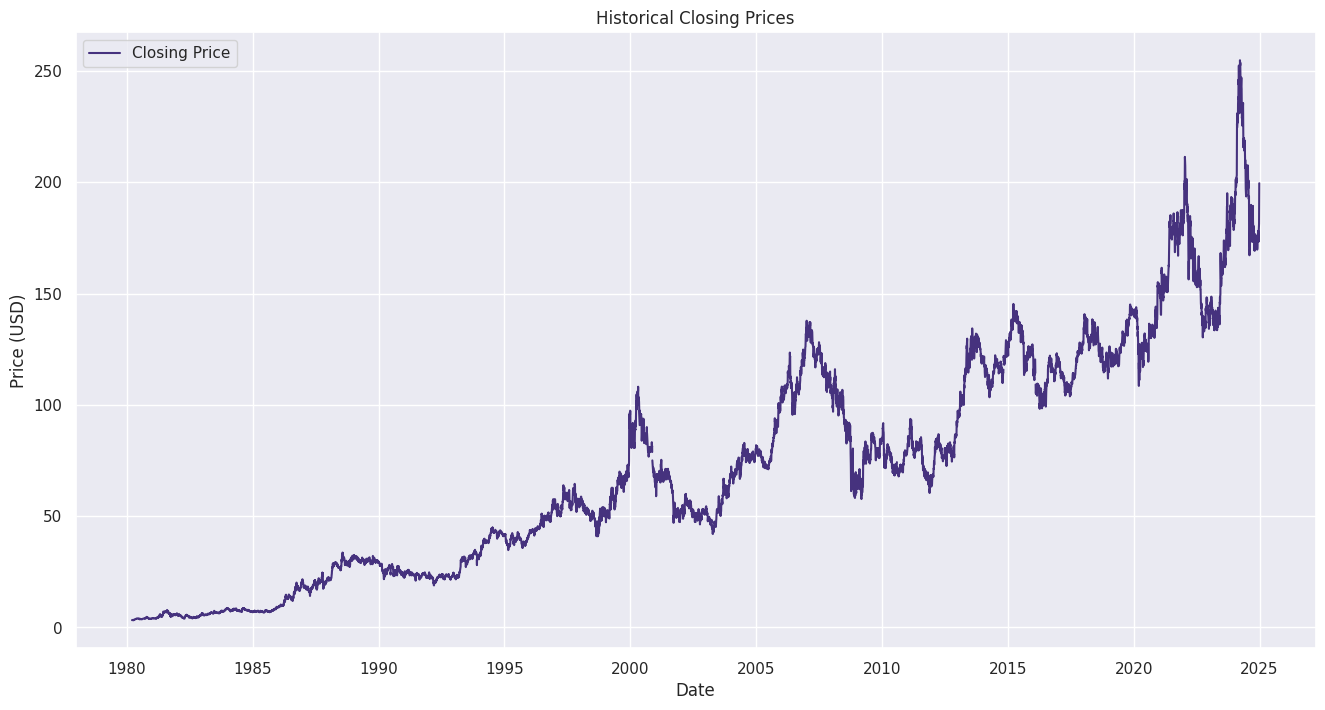

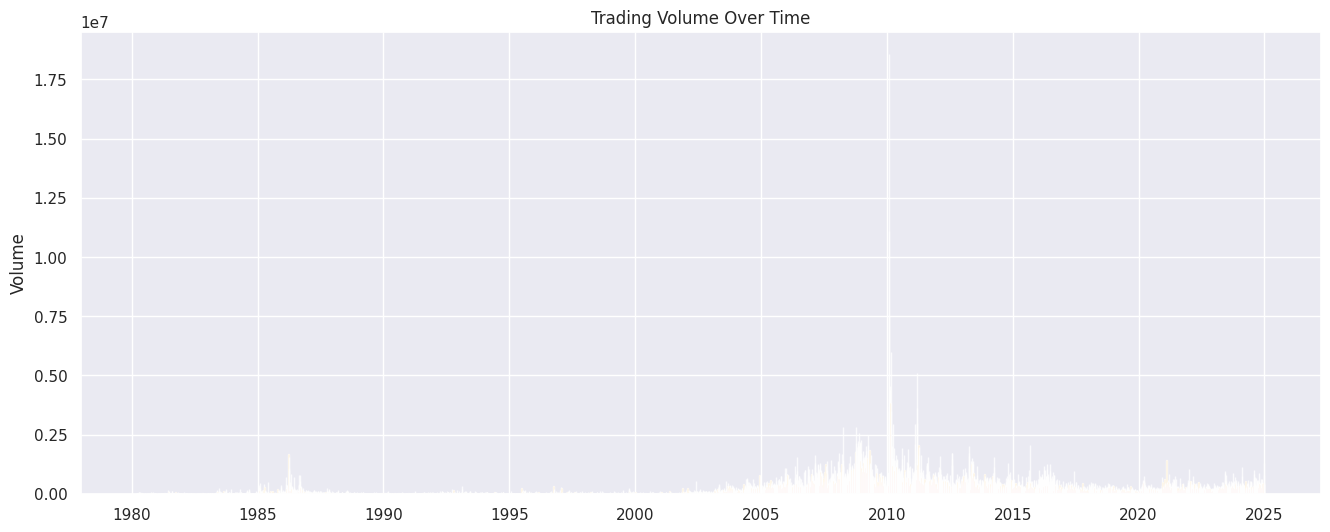

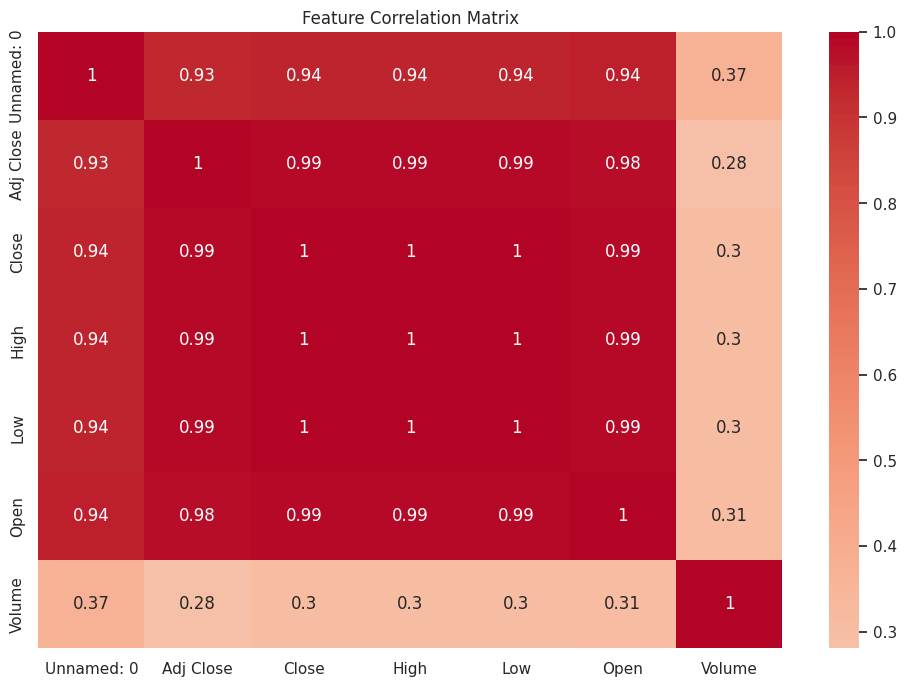

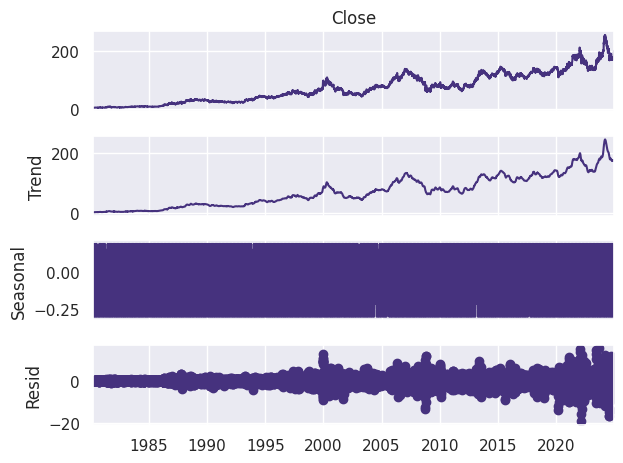

In [3]:
# Price History
plt.figure(figsize=(16, 8))
plt.plot(df['Close'], label='Closing Price')
plt.title('Historical Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.savefig('closing_prices.png')
plt.show()

# Volume Analysis
plt.figure(figsize=(16, 6))
plt.bar(df.index, df['Volume'], color='orange', alpha=0.8)
plt.title('Trading Volume Over Time')
plt.ylabel('Volume')
plt.savefig('volume.png')
plt.show()

# Correlation Matrix
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.savefig('correlation.png')
plt.show()

# Seasonal Decomposition
result = seasonal_decompose(df['Close'], model='additive', period=30)
result.plot()
plt.tight_layout()
plt.savefig('seasonal_decomp.png')
plt.show()

 ### 4. Advanced Feature Engineering

In [4]:
def create_features(df):
    # Technical Indicators
    for window in [5, 20, 50]:
        df[f'MA_{window}'] = df['Close'].rolling(window).mean()
        df[f'Volatility_{window}'] = df['Close'].rolling(window).std()
        df[f'ROC_{window}'] = df['Close'].pct_change(window) * 100

    # Bollinger Bands
    df['BB_Upper'] = df['MA_20'] + 2*df['Volatility_20']
    df['BB_Lower'] = df['MA_20'] - 2*df['Volatility_20']
    df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower'])/df['MA_20']

    # MACD
    df['EMA12'] = df['Close'].ewm(span=12).mean()
    df['EMA26'] = df['Close'].ewm(span=26).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']

    # RSI
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Target Variable (5-day future price)
    df['Target'] = df['Close'].shift(-5)

    df.dropna(inplace=True)
    return df

featured_df = create_features(df)
print("\nEngineered Features Sample:")
print(featured_df.tail())


Engineered Features Sample:
            Unnamed: 0   Adj Close       Close        High         Low  \
Date                                                                     
2024-12-13       11281  175.860001  175.860001  176.270004  175.050003   
2024-12-16       11282  174.250000  174.250000  174.970001  173.850006   
2024-12-17       11283  173.279999  173.279999  174.630005  173.279999   
2024-12-18       11284  173.619995  173.619995  179.369995  173.550003   
2024-12-19       11285  174.210007  174.210007  175.800003  173.770004   

                  Open    Volume        MA_5  Volatility_5     ROC_5  ...  \
Date                                                                  ...   
2024-12-13  176.169998  225800.0  176.725998      0.990061 -0.051149  ...   
2024-12-16  174.570007  327400.0  176.173999      1.453210 -1.559231  ...   
2024-12-17  174.000000  421000.0  175.687997      1.963813 -1.382965  ...   
2024-12-18  177.330002  457900.0  174.781998      1.544124 -2.54280

 ### 5. Data Preparation

In [5]:
# Feature Selection
features = ['Close', 'MA_5', 'MA_20', 'Volatility_20',
           'ROC_5', 'BB_Width', 'MACD', 'RSI']
target = 'Target'

# Chronological Split
train_size = int(len(featured_df) * 0.8)
train = featured_df.iloc[:train_size]
test = featured_df.iloc[train_size:]

# Normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train[features])
X_test = scaler.transform(test[features])
y_train = train[target]
y_test = test[target]

 ### 6. Model Development

In [6]:
# Model Training Function
def train_evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    print(f"{model_name} Results:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}\n")
    return pred

# Initialize Models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100)
}

predictions = {}
for name, model in models.items():
    predictions[name] = train_evaluate_model(model, name)

Linear Regression Results:
RMSE: 5.0490
MAE: 3.5347

Random Forest Results:
RMSE: 28.3768
MAE: 16.6875

Gradient Boosting Results:
RMSE: 28.9442
MAE: 16.9419



 ### 7. LSTM Implementation

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0113 - val_loss: 0.0022
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9.7337e-04 - val_loss: 8.2861e-04
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9.5758e-04 - val_loss: 9.0199e-04
Epoch 7/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.6641e-04 - val_loss: 0.0024
Epoch 8/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7.6379e-04 - val_loss: 9.5667e-04
Epoch 9/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.2853e-04 - val_loss: 4.9670e-04
Epoch 10/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 6.6438e-04 - val_loss: 0.0018
Epoch 11/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.0826e-04 - val_loss: 0

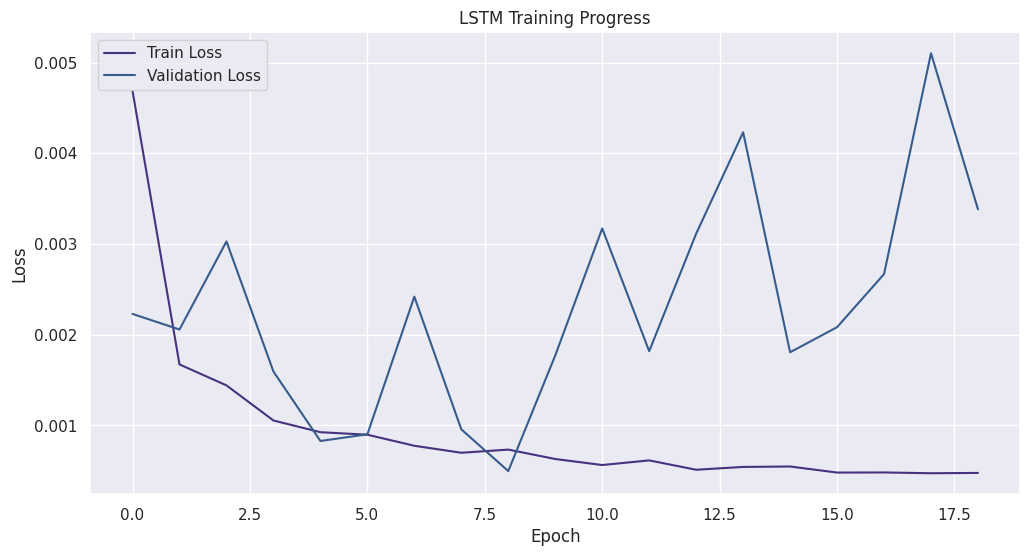

In [7]:
# Reshape Data for LSTM
def create_sequences(data, n_steps=30):
    X, y = [], []
    for i in range(len(data)-n_steps-5):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps:i+n_steps+5, 0])  # First column is Close price
    return np.array(X), np.array(y)

X_train_lstm, y_train_lstm = create_sequences(X_train)
X_test_lstm, y_test_lstm = create_sequences(X_test)

# Build LSTM Model
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(5)
])

lstm_model.compile(optimizer='adam', loss='mse')

# Training
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Plot Training History
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('lstm_training.png')
plt.show()

 ### 8. Model Evaluation

In [10]:
# Generate Predictions
lstm_pred = lstm_model.predict(X_test_lstm)

# Calculate Metrics
def calculate_metrics(true, pred):
    # Adjust the length of 'true' to match 'pred'
    true = true[-len(pred):]  # Take only the last 'len(pred)' elements of 'true'

    # Reshape pred to have the same shape as true
    pred = pred[:, 0] # Assuming you want to compare with the first predicted value

    rmse = math.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    direction_acc = np.mean((np.diff(true) * np.diff(pred)) > 0) * 100
    return rmse, mae, direction_acc

print("LSTM Evaluation:")
lstm_rmse, lstm_mae, lstm_dir_acc = calculate_metrics(y_test, lstm_pred)
print(f"RMSE: {lstm_rmse:.4f}")
print(f"MAE: {lstm_mae:.4f}")
print(f"Directional Accuracy: {lstm_dir_acc:.2f}%")

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LSTM Evaluation:
RMSE: 147.9759
MAE: 144.6760
Directional Accuracy: 47.83%


 ### 9. Trading Simulation


Gradient Boosting Trading Results:

Final Portfolio Value: $17564.66
Total Return: 75.65%


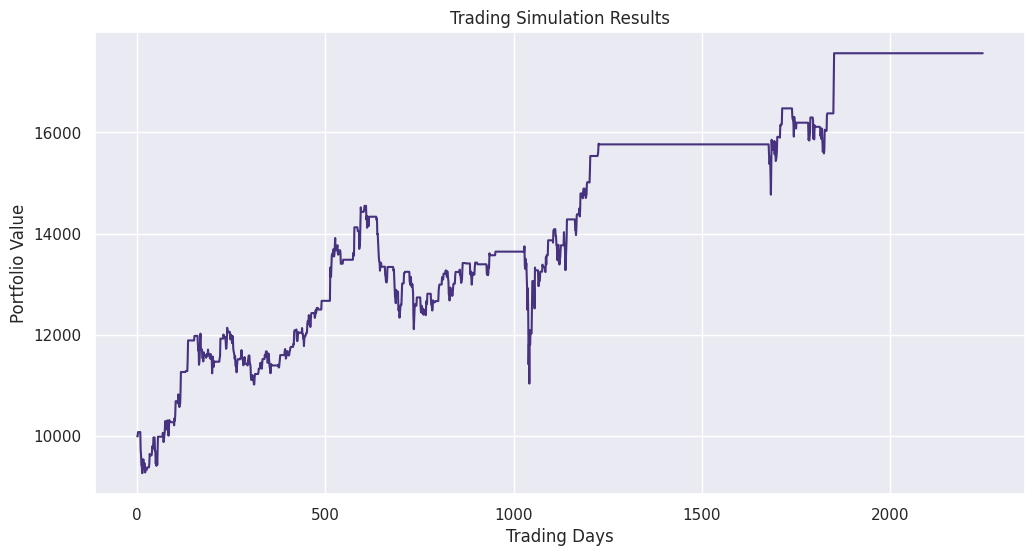

In [11]:
def trading_simulation(y_true, y_pred, initial_capital=10000):
    capital = initial_capital
    shares = 0
    portfolio = [capital]

    for i in range(1, len(y_pred)):
        current_price = y_true[i]
        predicted_change = y_pred[i] - y_true[i-1]

        if predicted_change > 0 and shares == 0:  # Buy signal
            shares = capital / current_price
            capital = 0
        elif predicted_change < 0 and shares > 0:  # Sell signal
            capital = shares * current_price
            shares = 0

        portfolio.append(capital + shares*current_price)

    returns = (portfolio[-1] - initial_capital)/initial_capital * 100
    print(f"\nFinal Portfolio Value: ${portfolio[-1]:.2f}")
    print(f"Total Return: {returns:.2f}%")

    plt.figure(figsize=(12, 6))
    plt.plot(portfolio)
    plt.title('Trading Simulation Results')
    plt.ylabel('Portfolio Value')
    plt.xlabel('Trading Days')
    plt.savefig('trading_simulation.png')
    plt.show()

# Run simulation with best model
print("\nGradient Boosting Trading Results:")
trading_simulation(y_test.values, predictions['Gradient Boosting'])

 ### 10. Model Interpretation & Limitations

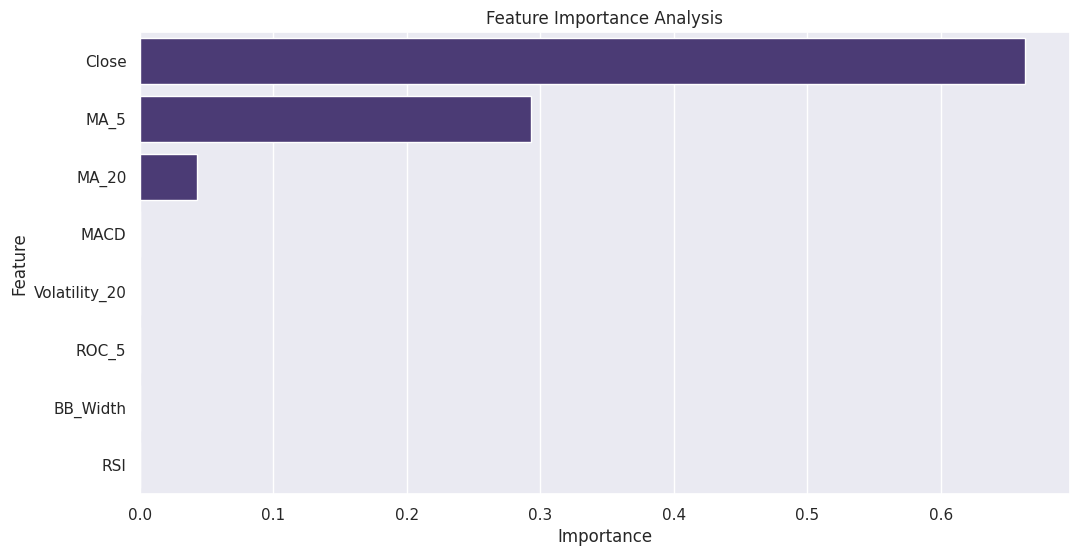


Model Limitations:
1. Limited ability to capture black swan events
2. Assumes stationarity in market conditions
3. No incorporation of external factors (news, earnings)
4. Lookback window limitations in LSTM architecture

Improvement Strategies:
- Incorporate alternative data sources
- Implement hybrid ARIMA-LSTM models
- Add attention mechanisms to LSTM
- Use walk-forward validation


In [12]:
# Feature Importance
gb = GradientBoostingRegressor().fit(X_train, y_train)
importance = pd.DataFrame({
    'Feature': features,
    'Importance': gb.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance)
plt.title('Feature Importance Analysis')
plt.savefig('feature_importance.png')
plt.show()

# Limitations Analysis
print("\nModel Limitations:")
print("1. Limited ability to capture black swan events")
print("2. Assumes stationarity in market conditions")
print("3. No incorporation of external factors (news, earnings)")
print("4. Lookback window limitations in LSTM architecture")

print("\nImprovement Strategies:")
print("- Incorporate alternative data sources")
print("- Implement hybrid ARIMA-LSTM models")
print("- Add attention mechanisms to LSTM")
print("- Use walk-forward validation")

In [14]:
# prompt: save models

# Save the trained LSTM model
lstm_model.save('lstm_model.h5')

# Save other models if needed (example for Gradient Boosting)
import joblib
joblib.dump(models['Gradient Boosting'], 'gradient_boosting_model.pkl')


['gradient_boosting_model.pkl']

 ### 11. Final Predictions Export

In [13]:
# Generate final predictions
final_pred = pd.DataFrame({
    'Date': test.index[30:-5],
    'Actual': y_test.values[30:-5],
    'Predicted': predictions['Gradient Boosting'][30:-5]
})

final_pred.to_csv('stock_predictions.csv', index=False)
print("\nPredictions saved to stock_predictions.csv")


Predictions saved to stock_predictions.csv
